In [1]:
import torch

# Configura el dispositivo
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")

In [2]:
!pip install lightning pytorch-lightning==1.9.5
!pip install torchvision

get_ipython().system('pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 46.1 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.0.post0
    Uninstalling pytorch-lightning-2.5.0.post0:
      Successfully uninstalled pytorch-lightning-2.5.0.post0
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-a6usim1i
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-a6usim1i
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 7021d63a49106e22c79b40564a7d39930e7b0f53
  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3880 sha256=1aba7dec4bba172f75fcab8beebf867aa377643

In [3]:
import torchvision.models as models

# Cargar el modelo ResNet50 con el parámetro 'weights'
resnet_model = models.resnet50(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


In [4]:
import pytorch_lightning as pl

print(f"PyTorch Lightning version: {pl.__version__}")

PyTorch Lightning version: 1.9.5


In [5]:
import os
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
import torchvision.models as resnet_models
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
from pytorch_lightning import LightningModule
import random
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from openslide import OpenSlide
import timm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
import os
print(os.listdir("/kaggle/input/final-tiles/combined_tiles"))

['isup_grade_2', 'isup_grade_1', 'isup_grade_5', 'isup_grade_4', 'isup_grade_3', 'isup_grade_0']


In [7]:
import os

# Ruta al dataset
dataset_path = "/kaggle/input/final-tiles"

# Verificar contenido del dataset
for grade_folder in sorted(os.listdir(dataset_path)):
    grade_path = os.path.join(dataset_path, grade_folder)
    if os.path.isdir(grade_path):
        image_folders = os.listdir(grade_path)
        print(f"Clase: {grade_folder}, Total imágenes: {len(image_folders)}")
        # Mostrar un ejemplo
        first_image_folder = os.path.join(grade_path, image_folders[0])
        tiles = [f for f in os.listdir(first_image_folder) if f.startswith('tile_')]
        print(f"Ejemplo - Carpeta de imagen: {image_folders[0]}, Total tiles: {len(tiles)}")

Clase: combined_tiles, Total imágenes: 6
Ejemplo - Carpeta de imagen: isup_grade_2, Total tiles: 0


In [8]:
import os
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import CyclicLR
    
# Configuración inicial
DEBUG = True  # Modo de depuración

kernel_type = 'how_to_train_resnet_to_get_LB_0.86'
SAVE_NAME = "ResNet50"
FP16 = True
resnet_type = 'resnet50'
tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 20
num_workers = min(batch_size, 4)
out_dim = 6  
init_lr = 3e-4
warmup_factor = 10
ACCUM_STEPS = 1
warmup_epo = 1
n_epochs = 30 

data_dir = "/kaggle/input/final-tiles/combined_tiles" 


data = []
for grade in range(6):  # ISUP grades 0 to 5
    grade_path = os.path.join(data_dir, f'isup_grade_{grade}')
    if os.path.exists(grade_path):
        for img_name in os.listdir(grade_path):
            if img_name.endswith(".png"):  # Ensure we're only picking up image files
                img_path = os.path.join(grade_path, img_name)
                image_id = img_name.replace("combined_", "").replace(".png", "")  # Extract image_id
                data.append({"image_path": img_path, "isup_grade": grade, "image_id": image_id})

# Convert to DataFrame
df_train = pd.DataFrame(data)

print(f"Total combined images in the dataset: {len(df_train)}")

# Assign folds for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (_, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i

# Verify the new dataset
device = torch.device('cuda')
print(df_train.head())


Total combined images in the dataset: 10597
                                          image_path  isup_grade  \
0  /kaggle/input/final-tiles/combined_tiles/isup_...           0   
1  /kaggle/input/final-tiles/combined_tiles/isup_...           0   
2  /kaggle/input/final-tiles/combined_tiles/isup_...           0   
3  /kaggle/input/final-tiles/combined_tiles/isup_...           0   
4  /kaggle/input/final-tiles/combined_tiles/isup_...           0   

                           image_id  fold  
0  019c1b40e6ec7410e8356c5d8d487954     0  
1  f7d4742181dbabcd86644ec7781c14b4     2  
2  12691983b96a9e8c7bc067fdd48b8d97     4  
3  41a2f4193aa1effcd56bac44e7affb03     3  
4  5968428558aa2438b6a420dfddb5829f     4  


In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(0)

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchvision import transforms
import os
import torch
import multiprocessing 
import os
import cv2
import torch
import timm
import numpy as np
import pandas as pd
import torch.nn as nn
import torchmetrics
import albumentations as A
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from timm.data import Mixup
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR


import torch.nn.functional as F

class PandaDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = self.df.iloc[idx]["isup_grade"]

        # Load image using OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)  # 🔹 Fix: Convert to PIL Image

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
from pytorch_lightning import LightningModule
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from sklearn.utils.class_weight import compute_class_weight
import torch
import timm
import torch
import torch.nn as nn
import torchmetrics
from pytorch_lightning import LightningModule


import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from pytorch_lightning import LightningModule


def ordinal_bce_loss(logits, target):
    ordinal_labels = (target.unsqueeze(1) >= torch.arange(1, 6, device=target.device)).float()
    return F.binary_cross_entropy_with_logits(logits, ordinal_labels, reduction="mean")



class OrdinalResNetModel(LightningModule):
    def __init__(self, resnet_type="resnet50", lr=1e-3, label_smoothing=0.1):
        super().__init__()
        self.lr = lr
        
        self.model = timm.create_model(resnet_type, pretrained=True, num_classes=0)
        self.feature_size = self.model.num_features

        self.head = nn.Linear(self.feature_size, 5)

        self.criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

        # Métricas
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=6)
        self.val_accuracy   = torchmetrics.Accuracy(task="multiclass", num_classes=6)

    def forward(self, x):
        features = self.model.forward_features(x)
        features = features.mean(dim=(-1, -2))  # Global Average Pool
        logits = self.head(features)
        return logits

    def training_step(self, batch, batch_idx):
        data, target = batch
        logits = self(data)

        loss = ordinal_bce_loss(logits, target)
        preds = (torch.sigmoid(logits) > 0.5).sum(dim=1).long()
        acc   = self.train_accuracy(preds, target)

       
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log("train_accuracy", acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        logits = self(data)
        loss = ordinal_bce_loss(logits, target)

        preds = (torch.sigmoid(logits) > 0.5).sum(dim=1).long()
        acc = self.val_accuracy(preds, target)

        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log("val_accuracy", acc, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=0.9,
            weight_decay=1e-3,
            nesterov=True
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.1,
            patience=2
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }


Entrenando Fold 1/5


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/plugins/precision/native_amp.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Entrenando Fold 2/5


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Entrenando Fold 3/5


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Entrenando Fold 4/5


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Entrenando Fold 5/5


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Dataset corregido guardado: 10597 muestras


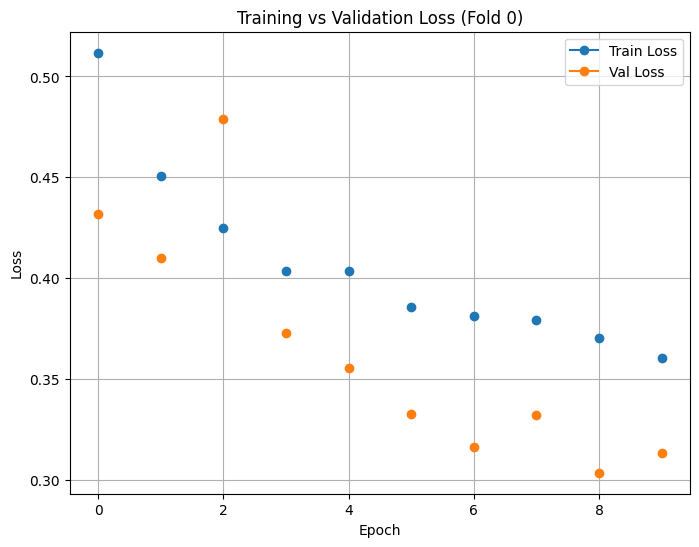

Loading model from: /kaggle/working/checks/fold_0/epochepoch=08-val_lossval_loss=0.3037.ckpt


/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=map_locati

QWK: 0.7594233234939387
Accuracy: 55.16753185464842 %
Confusion Matrix: [[427 113  10   8   5   1]
 [ 65 386  63   9   2   0]
 [ 13 113 126  13   2   0]
 [  5  43  92  80  45   5]
 [ 13  32  38  64  71  23]
 [  9  13  17  44  90  79]]


In [12]:
import os
import numpy as np
import torch
import cv2
from PIL import Image
from torch.utils.data import DataLoader, Dataset, SequentialSampler, WeightedRandomSampler
from torchvision import transforms
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score


n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

all_preds = []
all_labels = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(df_train)):
    print(f"Entrenando Fold {fold+1}/{n_folds}")

    # Transforms
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(20),
        transforms.ToTensor()
    ])
    valid_transforms = transforms.Compose([
        transforms.ToTensor()
    ])

    # Datasets
    dataset_train = PandaDataset(df_train.iloc[train_idx], transform=train_transforms)
    dataset_valid = PandaDataset(df_train.iloc[valid_idx], transform=valid_transforms)

    labels_train = dataset_train.df["isup_grade"].values
    class_counts = np.bincount(labels_train)
    total_samples = len(labels_train)
    weights = 1.0 / class_counts[labels_train]

    sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=total_samples,
        replacement=True
    )

    train_loader = DataLoader(
        dataset_train,
        batch_size=7,
        sampler=sampler,
        num_workers=4
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=7,
        sampler=SequentialSampler(dataset_valid),
        num_workers=4
    )

    # Modelo
    model = OrdinalResNetModel(
        resnet_type="resnet50",
        lr=1e-2,
        label_smoothing=0.1
    )

    # Callbacks
    save_dir = f"/kaggle/working/checks/fold_{fold}/"
    os.makedirs(save_dir, exist_ok=True)

    checkpoint_callback = ModelCheckpoint(
        dirpath=save_dir,
        filename="epoch{epoch:02d}-val_loss{val_loss:.4f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1
    )
    csv_logger = CSVLogger(save_dir=save_dir, name=f"training_logs_fold_{fold}")
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        patience=7,
        verbose=True,
        mode="min"
    )

    # Trainer
    trainer = Trainer(
        max_epochs=10,
        accelerator="gpu",
        devices=1,
        precision=16,  
        logger=csv_logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        num_sanity_val_steps=0
    )

    trainer.fit(model, train_loader, valid_loader)

    # Evaluación para mislabeled
    model.eval().cuda()  
    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for data, labels in valid_loader:
            data = data.cuda()  
            logits = model(data)
            preds = (torch.sigmoid(logits) > 0.5).sum(dim=1).cpu().numpy()

            fold_preds.extend(preds)
            fold_labels.extend(labels.numpy())

    all_preds.append(fold_preds)
    all_labels.append(fold_labels)

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


diffs = np.abs(all_preds - all_labels)
mask_mislabeled = (diffs > 2).mean(axis=0) > 0.1

df_train["mislabeled"] = False
df_train.loc[df_train.iloc[valid_idx].index, "mislabeled"] = mask_mislabeled

df_train_clean = df_train[~df_train["mislabeled"]].copy()
df_train_clean.to_csv("train_corrected.csv", index=False)
print(f"Dataset corregido guardado: {len(df_train_clean)} muestras")


import matplotlib.pyplot as plt

log_path = "/kaggle/working/checks/fold_0/training_logs_fold_0/version_0/metrics.csv"
df_metrics = pd.read_csv(log_path)

df_metrics = df_metrics.dropna(subset=["epoch"])
df_metrics["epoch"] = df_metrics["epoch"].astype(int)

train_loss = df_metrics["train_loss"]
val_loss   = df_metrics["val_loss"]
epochs     = df_metrics["epoch"]

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Fold 0)")
plt.legend()
plt.grid(True)
plt.show()

checkpoint_dir = "/kaggle/working/checks/fold_0/"
ckpt_files = [f for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
ckpt_files.sort(key=lambda f: os.path.getmtime(os.path.join(checkpoint_dir, f)), reverse=True)
best_ckpt = os.path.join(checkpoint_dir, ckpt_files[0])
print(f"Loading model from: {best_ckpt}")

model_infer = OrdinalResNetModel.load_from_checkpoint(best_ckpt, resnet_type="resnet50", lr=1e-2, label_smoothing=0.1)
model_infer.eval().cuda()  # Aseguramos float32 en GPU

test_loader = DataLoader(dataset_valid, batch_size=7, sampler=SequentialSampler(dataset_valid), num_workers=4)

predictions = []
true_classes = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.cuda()
        # data = data.half()  # si insistes en half. Si te da error, mantén float32
        logits = model_infer(data)
        preds = (torch.sigmoid(logits) > 0.5).sum(dim=1).cpu().numpy()

        predictions.extend(preds)
        true_classes.extend(targets.numpy())

conf_matrix = confusion_matrix(true_classes, predictions)
qwk = cohen_kappa_score(true_classes, predictions, weights='quadratic')
acc = accuracy_score(true_classes, predictions)*100

print("QWK:", qwk)
print("Accuracy:", acc, "%")
print("Confusion Matrix:", conf_matrix)